# Firing rate density biases

author: steeve.laquitaine@epfl.ch

modified: 01.06.2023

TODO:
- unit-test

## Setup

Setup virtual env `env_kilosort_silico`

```bash
pip3.9 install -r requirements_kilosort_silico.txt
```

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import spikeinterface as si
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import get_missed_units, get_detected_units
from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.postpro.feateng import (
    add_firing_rates, test_add_firing_rates, add_true_spike_count, add_sorted_spike_count, test_add_true_spike_count, test_add_sorted_spike_count
    )

from src.pipes.figures.p_bias_factors import engineer_detected_unit_features, get_drivers_of_density_biases, plot_cell_drivers_of_bias, plot_missed_cells_rate_hist

# SET RUN CONFIG
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()

# SET PARAMETERS
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"


# SET PATHS

# set Kilosort sorted spikes and cells path
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# set ground truth spikes and cells path
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

2023-06-02 12:05:57,200 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-02 12:05:57,247 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-06-02 12:05:57,250 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-02 12:05:57,294 - root - utils.py - get_config - INFO - Reading experiment config. - done


Studies have shown that sorters errors depend on cell's firing rate (spike counts). It is useful to look at what happens to cells sorted by their firing rate.

A simple hypothesis is that the sorter misses cells, which could explain the reduction in proportion of low firing cells on the "bias plot (red)" after sorting. Alternatively the sorter could simply assign false positive spikes to these cells raising their firing rate.

- the sorter `misses most cells, for the most part those that fire below 0.1 Hz` which supports the first hypothesis.

### Match true and sorted units

In [2]:
# get matching object
MatchingObject = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)

In [3]:
# Format as dataframe
match = match_sorted_to_true_neuropixels_2023_02_19(GT_SORTING_PATH, KS3_SORTING_PATH)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit"][
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["missed"][cell_matching["true_unit"].isin(missed)] = True


### Add firing rates

In [4]:
# add firing rate
matching = match["cell_matching"]
matching = add_firing_rates(matching, GT_SORTING_PATH, KS3_SORTING_PATH, data_conf)

# add spike counts
matching = add_true_spike_count(matching, data_conf)
matching = add_sorted_spike_count(matching, data_conf)

2023-06-02 10:13:55,890 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-02 10:13:55,936 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [5]:
matching

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,true_unit,sorted_unit,oversplit,missed,true firing rate,ks3 firing rate,true spike count,sorted spike count
0,19690.0,298.0,True,False,0.009091,2.016404,5.0,1109.0
1,397844.0,298.0,True,False,0.007273,2.016404,4.0,1109.0
2,499827.0,298.0,True,False,1.541849,2.016404,848.0,1109.0
3,1415062.0,298.0,True,False,0.001818,2.016404,1.0,1109.0
4,2795437.0,298.0,True,False,1.463666,2.016404,805.0,1109.0
...,...,...,...,...,...,...,...,...
622,NaN,289.0,NaN,NaN,NaN,0.425463,NaN,234.0
623,NaN,290.0,NaN,NaN,NaN,1.874583,NaN,1031.0
624,NaN,294.0,NaN,NaN,NaN,0.343643,NaN,189.0
625,NaN,295.0,NaN,NaN,NaN,0.572739,NaN,315.0


In [6]:
# unit-tests
test_add_firing_rates()
test_add_true_spike_count()
test_add_sorted_spike_count()

### Sort missed and detected units

In [7]:
# get missed units
missed_units = get_missed_units(MatchingObject.agreement_scores)
missed_data = matching[matching["true_unit"].isin(missed_units)]

# get detected units
detected_units = get_detected_units(MatchingObject.agreement_scores)
detected_data = matching[matching["true_unit"].isin(detected_units)]

### Featurize detected units data

In [8]:
# engineer
features = engineer_detected_unit_features(detected_data, LOW_RATE_CEILING, MID_RATE_CEILING)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/figures/p_bias_factors.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["true_firing_rate_feat"] = true_rate
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/figures/p_bias_factors.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats["true_firing_rate_feat"][neg_p_bias_loc] = "neg_p_bias"
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/figures/p_bias_factors.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

### Identify the causes of cell sorting firing probability biases

In [67]:
# get the causes
causes_out = get_drivers_of_density_biases(features, LOW_RATE_CEILING, MID_RATE_CEILING)

## Sparse firing unit misses and firing rate overestimation when detected explains firing rate density biases

- Sparse firing units (< 0.2Hz) are missed.
- cell misses (top panel) and overestimation of the firing rate of detected cells' firing below 1Hz, together explain the changes in the firing rate distribution (there are less sparse cells).

2023-06-02 11:13:39,706 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-02 11:13:39,753 - root - utils.py - get_config - INFO - Reading experiment config. - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles inst

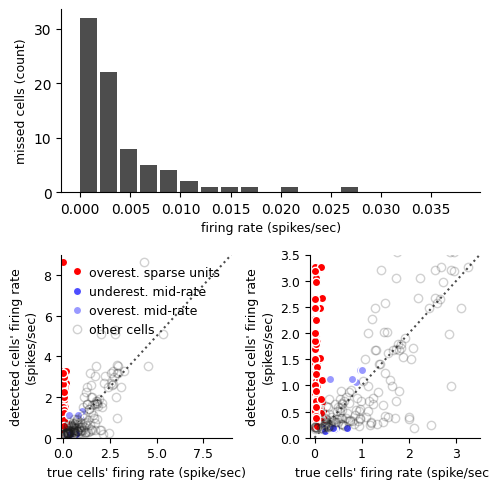

In [69]:
# setup figure
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])

# make sure are no duplicates true unit firing rates
missed_data_for_plot = missed_data.drop_duplicates(subset=['true_unit'])

# plot missed cells cause of biases (against firing rate)
ax1 = plot_missed_cells_rate_hist(ax1, missed_data, x_max=0.04, bin_step=0.002, bin_width=0.0017, title="")

# plot detected cells' cause of biases
ax2 = fig.add_subplot(gs[1, 0])
ax2 = plot_cell_drivers_of_bias(
    ax2, 
    causes_out["overest_sparse_units"], 
    causes_out["underest_mid_rate"],
    causes_out["overest_mid_rate"],
    causes_out["unbiased_cells"], 
    x_max=9, 
    y_max=9, 
    legend=True, 
    title="", 
    ylabel=True
    )

# plot detected cells' cause of biases
ax3 = fig.add_subplot(gs[1, 1])
ax3 = plot_cell_drivers_of_bias(
    ax3, 
    causes_out["overest_sparse_units"], 
    causes_out["underest_mid_rate"],
    causes_out["overest_mid_rate"],
    causes_out["unbiased_cells"], 
    x_max=3.5, 
    y_max=3.5, 
    legend=False, 
    title="", 
    ylabel=True
    )
plt.tight_layout()

## There are no silent units

TODO:
- I have run a few tests on "add_sorted_spike_count" but need to create unit-tests

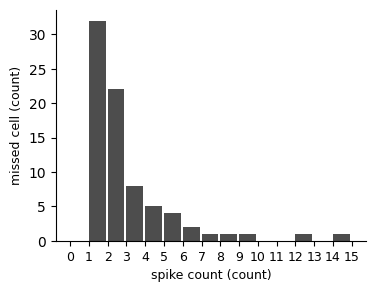

In [262]:
# plot spike count distribution
fig, axis = plt.subplots(figsize=(4,3))

# create bins
bins = np.arange(0,16,1)

# bar sparse cells
missed_data_for_hist = missed_data[["true_unit", "true spike count"]].drop_duplicates(subset=['true_unit'])
axis = missed_data_for_hist["true spike count"].hist(bins=bins, width=0.9, color=[0.3, 0.3, 0.3], linewidth=2, facecolor=[0.3, 0.3, 0.3]);

# legend
axis.set_xlabel("spike count (count)", fontsize=9);
axis.set_ylabel("missed cell (count)", fontsize=9);
axis.grid(False);
axis.spines[["right", "top"]].set_visible(False);
axis.set_xticks(bins);
axis.set_xticklabels(bins, fontsize=9);

In [49]:
true_rate = matching[["true_unit","true firing rate"]].dropna()

# count sparse true units
n_sparse_units = sum(true_rate["true firing rate"] < LOW_RATE_CEILING)
print("sparse units (count):", n_sparse_units)

# count missed sparse units
missed_rate = missed_data[["true_unit", "true firing rate"]].dropna()
n_missed_units = sum(missed_rate["true firing rate"] < LOW_RATE_CEILING)
print("missed sparse units (count):", n_missed_units)
print("missed sparse units (ratio to sparse units):", n_missed_units/n_sparse_units)

sparse units (count): 370
missed sparse units (count): 78
missed sparse units (ratio to sparse units): 0.21081081081081082


TODO
- show that sparse cells (below 1Hz have much lower sorting accuracies (max agreement score) than more active cells)

In [267]:
detected_data

,true_unit,sorted_unit,oversplit,missed,true firing rate,ks3 firing rate,true spike count,sorted spike count
0,19690.0,298.0,True,False,0.009091,2.016404,5.0,1109.0
1,397844.0,298.0,True,False,0.007273,2.016404,4.0,1109.0
2,499827.0,298.0,True,False,1.541849,2.016404,848.0,1109.0
3,1415062.0,298.0,True,False,0.001818,2.016404,1.0,1109.0
4,2795437.0,298.0,True,False,1.463666,2.016404,805.0,1109.0
...,...,...,...,...,...,...,...,...
529,4209594.0,268.0,True,False,0.021819,0.894563,12.0,492.0
530,4211868.0,135.0,True,False,0.027273,0.380008,15.0,209.0
531,4229506.0,135.0,True,False,0.567284,0.380008,312.0,209.0
532,4217493.0,241.0,True,False,0.025455,0.581830,14.0,320.0


### Check feature counts

In [263]:
# features[["rate_change_feat", "oversplit_feat", "true_firing_rate_feat"]].groupby(["true_firing_rate_feat","rate_change_feat"]).size()

In [264]:
# features[["rate_change_feat", "oversplit_feat", "true_firing_rate_feat"]].groupby(["true_firing_rate_feat","rate_change_feat","oversplit_feat"]).size()

In [265]:
# features[["rate_change_feat", "oversplit_feat", "true_firing_rate_feat"]].groupby(["oversplit_feat", "true_firing_rate_feat","rate_change_feat"]).size()